In [1]:
import pysam
import os
import sys
directory_path = os.path.abspath(os.path.join('../src/'))
if directory_path not in sys.path:
    sys.path.append(directory_path)
    
from read_process import get_contig_lengths_dict,\
incorporate_replaced_pos_info,incorporate_insertions_and_deletions,\
get_positions_from_md_tag,reverse_complement,get_edit_information,get_edit_information_wrapper,\
has_edits,get_dataframe_from_barcode_dict,get_total_coverage_for_contig_at_position,\
print_read_info, update_coverage_array, add_read_information_to_barcode_dict


# An example on a bam for just one cell barcode (split from the original bam)

### in 10X's bam file, xf=25 means that read is uniquely mapped to a genome, and was used for counting UMI. So we should only look at reads with xf=25 from the 10X bam.

In [2]:
barcode = 'AAACCCAAGATTGCGG'
bampath = '../data/group0_data/filtered_keep_xf25_possorted_genome_with_header.bam_MD.bam_MD-{}-1.bam'.format(barcode)

In [3]:
samfile = pysam.AlignmentFile(bampath, "rb")

# Full test

In [57]:
from collections import defaultdict
import time
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

# TOLERANCES/THRESHOLD FOR FILTERING
edit_type_of_interest = 'C>T'

dist_from_end_tolerance = 3
base_quality_threshold = 37
mapping_quality_threshold = 255

# DICTIONARIES TO FILL WITH EDIT INFORMATION
barcode_to_position_to_alts = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:defaultdict())))) 


contig_lengths_dict = get_contig_lengths_dict(samfile)

# THE HEAVY LIFTING
counts = defaultdict(lambda:0)
coverage_dict = {}
num_edits_per_read = {}
mapping_quality_per_read = {}

ref_positions_for_reads_with_high_edit_counts = {}
    
EDITED_CODE = 'edited'
deletions = []

contigs = []
for contig in contig_lengths_dict.keys():
    try:
        contig_length = contig_lengths_dict.get(contig)
        reads_for_contig = samfile.fetch(contig, 0, contig_length)
        barcode_to_coverage_dict = defaultdict()

        for i, read in enumerate(reads_for_contig):
            reference_positions_covered_by_read = update_coverage_array(read, contig, contig_length, barcode_to_coverage_dict)

            error_code, num_edits_of_each_type = add_read_information_to_barcode_dict(read, contig, barcode_to_position_to_alts)
        
            if error_code:
                counts[error_code] += 1
                if error_code == 'deletion':
                    deletions.append(read)
            else:
                counts[EDITED_CODE] += 1
                num_edits_per_read[str(read.query_name)] = num_edits_of_each_type
                
        coverage_dict[contig] = barcode_to_coverage_dict
        contigs.append(contig)
    except Exception as e:
        print(contig, e)

Stamp "tag 'MD' not present"


In [58]:
counts

defaultdict(<function __main__.<lambda>()>,
            {'edited': 6589, 'no_edits': 27557, 'deletion': 184})

# Check out deletions

In [67]:
read = deletions[0]

read_barcode = read.get_tag('CR')
is_reverse = read.is_reverse
reference_start = read.reference_start
reference_end = read.reference_end
read_id = read.query_name


def incorporate_insertions_and_deletions(aligned_sequence, cigar_tuples):
    """
    Update an aligned sequence to reflect any insertions (take away those positions) such
    that it can be better compared base-to-base to a reference sequence.
    """
    new_seq = ''
    
    current_pos = 0
    for mod, num_bases in cigar_tuples:
        if mod == 0:
            # match
            new_seq += aligned_sequence[current_pos:current_pos+num_bases]
            current_pos += num_bases
        if mod in [1, 4]:
            # insertion or soft-clipping
            current_pos += num_bases
        if mod in [2]:
            # deletion
            new_seq += ''.join(['*' for r in range(num_bases)])
            
    return new_seq

def get_edit_information(md_tag, cigar_tuples, aligned_seq, reference_seq, query_qualities, hamming_check=False):   
    print(cigar_tuples)
    fixed_aligned_seq = incorporate_insertions_and_deletions(aligned_seq, cigar_tuples)
    print(fixed_aligned_seq)
    positions_replaced = get_positions_from_md_tag(md_tag)
    
    indicated_aligned_seq, alt_bases = incorporate_replaced_pos_info(fixed_aligned_seq, positions_replaced)
    indicated_reference_seq, ref_bases = incorporate_replaced_pos_info(reference_seq, positions_replaced)
    indicated_qualities, qualities = incorporate_replaced_pos_info(query_qualities, positions_replaced, qualities=True)
    
    if hamming_check:
        hamming_distance = get_hamming_distance(indicated_aligned_seq, indicated_reference_seq)
        print("Hamming distance: {}".format(hamming_distance))
        assert(hamming_distance == len(alt_bases))
        
    return alt_bases, ref_bases, qualities, positions_replaced
    
    
def get_edit_information_wrapper(read, reverse, hamming_check=False):
    md_tag = read.get_tag('MD')
    print(md_tag)
    cigar_tuples = read.cigartuples
    aligned_seq = read.get_forward_sequence()
    query_qualities = read.query_qualities
    
    if not reverse:
        aligned_seq = reverse_complement(aligned_seq)
    
    reference_seq = read.get_reference_sequence().lower()
    print(reference_seq.upper())
    print(aligned_seq)
    return(get_edit_information(md_tag,
                                cigar_tuples, 
                                aligned_seq, 
                                reference_seq,
                                query_qualities,
                                hamming_check=hamming_check))

# PROCESS READ TO EXTRACT EDIT INFORMATION
strand = '+'
if is_reverse:
    strand = '-'
    
    
alt_bases, ref_bases, qualities, positions_replaced = get_edit_information_wrapper(read, not is_reverse)


23C11C3G12^C37C0T4C0T4
AGTATCAAATTATATCTTTTGGACATTGTTTTTATCAGAGATAAAAGATGAGCAAAATTAGCTCTACTTTATAAAAGATGATTTTTTTTTCTTTTTCTTTTT
AGTATCAAATTATATCTTTTGGAAATTGTTTTTATAAGATATAAAAGATGAGAAAATTAGCTCTACTTTATAAAAGATGATTTTTTTTTTCTTTTTCTTTT
[(0, 52), (2, 1), (0, 49)]
AGTATCAAATTATATCTTTTGGAAATTGTTTTTATAAGATATAAAAGATGAG*AAAATTAGCTCTACTTTATAAAAGATGATTTTTTTTTTCTTTTTCTTTT
Failed on ['2', '3', '-', '1', '1', '-', '3', '-', '1', '2', '-', '-', '3', '7', '-', '0', '-', '4', '-', '0', '-', '4'], invalid literal for int() with base 10: ''


TypeError: argument of type 'NoneType' is not iterable

### Random statistics / data we can leverage later if we want to enable filtering by number of edits per read...

In [41]:
num_edits_per_read_df = pd.DataFrame(num_edits_per_read).T.fillna(0)

In [42]:
num_edits_per_read_df

,G>T,C>A,G>C,A>G,T>A,A>C,C>T,T>C,C>G,T>G,G>A,A>T,A>N,T>N,G>N,C>N
A01535:287:H3JJHDSX7:1:1256:24496:23531,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A01535:287:H3JJHDSX7:2:2546:20699:21277,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A01535:287:H3JJHDSX7:1:1429:7934:26130,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A01535:287:H3JJHDSX7:1:2675:15438:23312,2.0,1.0,1.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A01535:287:H3JJHDSX7:1:1610:3974:22592,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A01535:287:H3JJHDSX7:1:2154:29170:15123,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
A01535:287:H3JJHDSX7:1:2665:26657:34006,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
A01535:287:H3JJHDSX7:2:1160:12626:1282,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A01535:287:H3JJHDSX7:1:1469:16767:17002,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# BUILD DATATFRAME

In [43]:
example_dataframe = get_dataframe_from_barcode_dict(barcode_to_position_to_alts)
print(len(example_dataframe))

12370


# ADD REFERENCE BASE COUNTS AT POSITION

In [44]:
example_dataframe['coverage'] = example_dataframe.apply(get_total_coverage_for_contig_at_position, args=(coverage_dict,), axis=1)


In [45]:
example_dataframe


,barcode,contig,position_ref,alt,read_id,strand,dist_from_read_end,quality,ref,position,coverage
0,AAACCCAAGATAGCGG,1,3210993_G,T,A01535:287:H3JJHDSX7:1:1256:24496:23531,-,44,11,G,3210993,1.0
1,AAACCCAAGATAGCGG,1,3210998_C,A,A01535:287:H3JJHDSX7:1:1256:24496:23531,-,39,11,C,3210998,1.0
2,AAACCCAAGATAGCGG,12,116256160_C,A,A01535:287:H3JJHDSX7:1:1301:12545:32581,-,15,11,C,116256160,1.0
3,AAACCCAAGATAGCGG,12,116256165_G,T,A01535:287:H3JJHDSX7:1:1301:12545:32581,-,20,11,G,116256165,1.0
4,AAACCCAAGATAGCGG,14,24493549_T,G,A01535:287:H3JJHDSX7:1:1525:5475:21371,+,79,11,T,24493549,0.0
...,...,...,...,...,...,...,...,...,...,...,...
12365,AAACCCAAGATTGCCG,9,53401686_T,A,A01535:287:H3JJHDSX7:1:1376:17680:11537,+,16,11,T,53401686,1.0
12366,ACACCCAAGATTGCGG,9,73037492_C,A,A01535:287:H3JJHDSX7:1:1622:18059:17112,-,33,11,C,73037492,1.0
12367,ACACCCAAGATTGCGG,9,73037494_G,T,A01535:287:H3JJHDSX7:1:1622:18059:17112,-,31,11,G,73037494,1.0
12368,ACACCCAAGATTGCGG,9,73037495_A,G,A01535:287:H3JJHDSX7:1:1622:18059:17112,-,30,11,A,73037495,1.0


# FILTER DATAFRAME

12370
6437
11704
6024


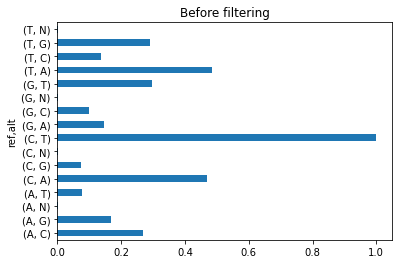

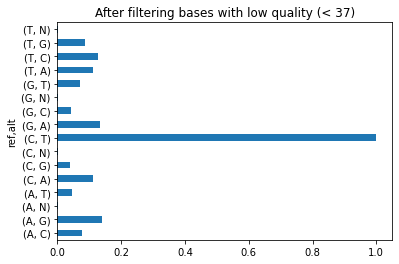

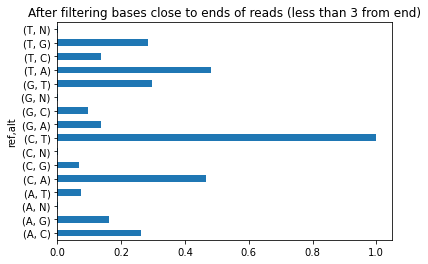

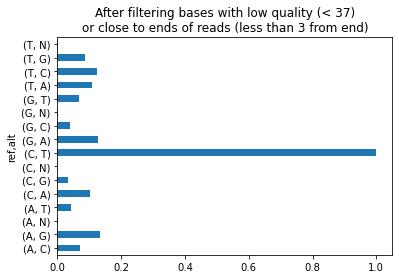

In [46]:
reads_to_filter = reads_to_filter_df.index


num_edits_per_read = pd.DataFrame(example_dataframe.groupby('read_id').count().barcode)
num_edits_per_read.columns = ['edits']

print(len(example_dataframe))
count_by_conversion = example_dataframe.groupby(['ref', 'alt']).count().barcode
count_by_conversion = count_by_conversion/count_by_conversion.max()
count_by_conversion.plot(kind='barh')
plt.title("Before filtering")


# Filter for base quality
example_dataframe_filtered = example_dataframe[(example_dataframe.quality.astype(int) >= base_quality_threshold)]
print(len(example_dataframe_filtered))
plt.figure()
count_by_conversion = example_dataframe_filtered.groupby(['ref', 'alt']).count().barcode
count_by_conversion = count_by_conversion/count_by_conversion.max()
count_by_conversion.plot(kind='barh')
_ = plt.title("After filtering bases with low quality (< {})".format(base_quality_threshold))




# Filter for distance from read end
example_dataframe_filtered = example_dataframe[(example_dataframe.dist_from_read_end > dist_from_end_tolerance)]
print(len(example_dataframe_filtered))
plt.figure()
count_by_conversion = example_dataframe_filtered.groupby(['ref', 'alt']).count().barcode
count_by_conversion = count_by_conversion/count_by_conversion.max()
count_by_conversion.plot(kind='barh')
_ = plt.title("After filtering bases close to ends of reads (less than {} from end)".format(dist_from_end_tolerance))



# Filter for distance from read end and base quality
example_dataframe_filtered = example_dataframe[(example_dataframe.dist_from_read_end > dist_from_end_tolerance) & (example_dataframe.quality.astype(int) >= base_quality_threshold)]
print(len(example_dataframe_filtered))
plt.figure()
count_by_conversion = example_dataframe_filtered.groupby(['ref', 'alt']).count().barcode
count_by_conversion = count_by_conversion/count_by_conversion.max()
count_by_conversion.plot(kind='barh')
_ = plt.title("After filtering bases with low quality (< {})\nor close to ends of reads (less than {} from end)".format(base_quality_threshold, dist_from_end_tolerance))



In [50]:
example_new_ct =  example_dataframe_filtered[(example_dataframe_filtered.ref == 'C') & (example_dataframe_filtered.alt == 'T')].sort_values('position')

In [51]:
len(example_new_ct)

3110

In [52]:
example_dataframe_filtered

,barcode,contig,position_ref,alt,read_id,strand,dist_from_read_end,quality,ref,position,coverage
32,AAACCCAAGATTGCGG,1,3419869_A,G,A01535:287:H3JJHDSX7:1:1429:7934:26130,-,18,37,A,3419869,1.0
35,AAACCCAAGATTGCGG,1,9942094_C,T,A01535:287:H3JJHDSX7:1:2511:17897:4961,-,15,37,C,9942094,2.0
36,AAACCCAAGATTGCGG,1,10034977_A,G,A01535:287:H3JJHDSX7:1:1265:28203:20776,-,14,37,A,10034977,1.0
37,AAACCCAAGATTGCGG,1,10137689_T,C,A01535:287:H3JJHDSX7:1:1241:22978:17550,-,24,37,T,10137689,4.0
38,AAACCCAAGATTGCGG,1,11232315_C,G,A01535:287:H3JJHDSX7:1:2130:32678:11146,+,5,37,C,11232315,1.0
...,...,...,...,...,...,...,...,...,...,...,...
12359,AAACCCGAGATTGCGG,MT,15041_A,C,A01535:287:H3JJHDSX7:1:1367:30056:8609,+,43,37,A,15041,1.0
12360,ANACCCAAGATTGCGG,2,121458251_C,T,A01535:287:H3JJHDSX7:1:1505:32850:8312,+,22,37,C,121458251,1.0
12361,ANACCCAAGATTGCGG,2,121458274_C,T,A01535:287:H3JJHDSX7:1:1505:32850:8312,+,45,37,C,121458274,1.0
12363,AAACCCAAAATTGCGG,5,33027730_C,T,A01535:287:H3JJHDSX7:1:1346:23773:10629,+,17,37,C,33027730,1.0


# Extract only reads for a barcode

In [53]:
# Get edits for barcode

example = pd.read_csv(
    '../data/group0_data/filtered_keep_xf25_possorted_genome_with_header.bam_MD.bam_MD-{}-1.bam.combined.readfiltered.formatted.varfiltered.snpfiltered.ranked.bed'.format(barcode),
    sep='\t', names=['contig', 'start', 'end', 'score', 'coverage', 'strand'])

comparison_vals = []
overlapping_by_contig = {}
for contig in contigs:
    print('contig {}'.format(contig))
    example_new_ct_for_contig = example_new_ct[example_new_ct.contig == contig]
    example_new_ct_for_contig.index = example_new_ct_for_contig.position

    example_old_ct_for_contig = example[example.contig == contig]
    example_old_ct_for_contig.index = example_old_ct_for_contig.start

    # Which overlap?
    
    overlapping = example_old_ct_for_contig.join(example_new_ct_for_contig, rsuffix='_2', how='inner').drop_duplicates(['contig', 'start', 'end', 'score'])
    overlapping['old_coverage'] = [int(v.split(',')[1]) for v in overlapping['coverage']]
    overlapping_by_contig[contig] = overlapping
    print("\tNumber of sites in old version: {}".format(len(example_old_ct_for_contig)))
    print("\tNumber of sites recapitulated: {}".format(len(overlapping)))
    
    comparison_vals.append([len(example_old_ct_for_contig), len(overlapping), len(example_new_ct_for_contig)])


contig 1
	Number of sites in old version: 11
	Number of sites recapitulated: 10
contig 10
	Number of sites in old version: 15
	Number of sites recapitulated: 13
contig 11
	Number of sites in old version: 32
	Number of sites recapitulated: 29
contig 12
	Number of sites in old version: 21
	Number of sites recapitulated: 18
contig 13
	Number of sites in old version: 3
	Number of sites recapitulated: 2
contig 14
	Number of sites in old version: 11
	Number of sites recapitulated: 10
contig 15
	Number of sites in old version: 19
	Number of sites recapitulated: 17
contig 16
	Number of sites in old version: 5
	Number of sites recapitulated: 5
contig 17
	Number of sites in old version: 17
	Number of sites recapitulated: 15
contig 18
	Number of sites in old version: 1
	Number of sites recapitulated: 1
contig 19
	Number of sites in old version: 23
	Number of sites recapitulated: 22
contig 2
	Number of sites in old version: 20
	Number of sites recapitulated: 20
contig 3
	Number of sites in old ver

# Which sites are we recovering?

In [54]:
recapitulation_summary = pd.DataFrame(comparison_vals, index=contigs, columns=['Previous sites', 'Overlapping sites', 'New sites'])

Text(0.5, 1.0, 'Sites from old approach recapitulated with new approach')

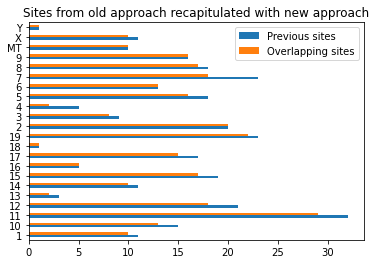

In [55]:
recapitulation_summary[['Previous sites', 'Overlapping sites']].head(22).plot(kind='barh')
plt.title("Sites from old approach recapitulated with new approach")

In [56]:
for contig in contigs:
    print(contig)
    corr = overlapping_by_contig.get(contig)[['old_coverage', 'coverage']].corr().iloc[0].iloc[0]
    print('\tCorrelation between old coverage and new coverage values: {}'.format(corr))

1
	Correlation between old coverage and new coverage values: 1.0
10
	Correlation between old coverage and new coverage values: 1.0
11
	Correlation between old coverage and new coverage values: 1.0
12
	Correlation between old coverage and new coverage values: 1.0
13
	Correlation between old coverage and new coverage values: 1.0
14
	Correlation between old coverage and new coverage values: 1.0
15
	Correlation between old coverage and new coverage values: 1.0
16
	Correlation between old coverage and new coverage values: 1.0
17
	Correlation between old coverage and new coverage values: 1.0
18
	Correlation between old coverage and new coverage values: nan
19
	Correlation between old coverage and new coverage values: 1.0
2
	Correlation between old coverage and new coverage values: 1.0
3
	Correlation between old coverage and new coverage values: 1.0
4
	Correlation between old coverage and new coverage values: 1.0
5
	Correlation between old coverage and new coverage values: 1.0
6
	Correlation 